Model taking BERT Token to feed into XGBoost Regressor

# Import Packages

In [1]:
!pip install transformers

In [2]:
import pandas as pd
import numpy as np
import os
import string
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Import Data

In [3]:
train_dataset = pd.read_csv("./data/train.csv")
test_dataset = pd.read_csv("./data/test.csv")

In [4]:
train_dataset.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [5]:
train_dataset.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [6]:
cohesion = train_dataset['cohesion']
syntax = train_dataset['syntax']
vocabulary = train_dataset['vocabulary']
phraseology = train_dataset['phraseology']
grammar = train_dataset['grammar']
conventions = train_dataset['conventions']

In [7]:
syntax = np.asarray(syntax)
cohesion = np.asarray(cohesion)
vocabulary = np.asarray(vocabulary)
phraseology = np.asarray(phraseology)
grammar = np.asarray(grammar)
conventions = np.asarray(conventions)

## Clean the full_text

In [8]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/moyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def CleanFeatures(sentences):
  sentences = sentences.apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
  sentences = sentences.apply(lambda wrd: ''.join(wrd))
  sentences = sentences.apply(lambda sequence:
                                            [word for word in sequence.split() if word not in stop_words])
  sentences = sentences.apply(lambda wrd: ' '.join(wrd))
  return sentences

In [10]:
full_text_train = CleanFeatures(train_dataset['full_text'])

In [11]:
full_text_test = CleanFeatures(test_dataset['full_text'])

# Tokenize Text

## Use BertTokenizer

In [12]:
from transformers import AutoTokenizer

In [13]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [14]:
tokens_train = []

In [15]:
for index, content in enumerate(full_text_train):
  tokens_train.append(tokenizer(content, max_length = 512, padding = "max_length",
                                 truncation = True, return_token_type_ids = True,
                                 return_tensors = 'np')['input_ids'])

In [16]:
tokens_train = np.asarray(tokens_train)

In [17]:
tokens_train.shape

(3911, 1, 512)

In [18]:
tokens_train = np.reshape(tokens_train, (tokens_train.shape[0], tokens_train.shape[2]))

In [19]:
tokens_train.shape

(3911, 512)

In [20]:
# save Bert Tokens for train
np.save("./data/train_BertToken.npy",tokens_train)

In [21]:
# do the same to test data
tokens_test = []
for index, content in enumerate(full_text_test):
  tokens_test.append(tokenizer(content, max_length = 512, padding = "max_length",
                                 truncation = True, return_token_type_ids = True,
                                 return_tensors = 'np')['input_ids'])
tokens_test = np.asarray(tokens_test)
tokens_test = np.reshape(tokens_test, (tokens_test.shape[0], tokens_test.shape[2]))

In [22]:
# save Bert Tokens for test
np.save("./data/test_BertToken.npy",tokens_test)

# XGBRegressor

## Load Preprocessed Data

In [23]:
train_token = np.load("./data/train_BertToken.npy")

In [24]:
test_token = np.load("./data/test_BertToken.npy")

## Analyze XGB model using kfold

In [25]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold

In [26]:
import xgboost as xgb

In [27]:
kfold = KFold(n_splits = 10,
              shuffle = True,
              random_state = 404)

In [28]:
y_train = np.transpose(np.asarray([cohesion, syntax, vocabulary, phraseology, grammar, conventions]))

In [29]:
cv_rmses = np.zeros((10,6))

# Use mean of rating as baseline to compare
cv_rmses_baseline = np.zeros((10,6))

i = 0
for train_ind, val_ind in kfold.split(train_token, y_train):
    x_t = train_token[train_ind]
    y_t = y_train[train_ind]
    
    x_val = train_token[val_ind]
    y_val = y_train[val_ind]
    
    xgb_estimator = xgb.XGBRegressor(n_estimators=100,
                                    max_depth = 2,
                                    objective='reg:squarederror')
    model = MultiOutputRegressor(xgb_estimator, n_jobs=3)

    model.fit(x_t, y_t)
    predicted = model.predict(x_val)
    
    bsl = np.ones((len(y_val),1))*np.mean(y_t, axis=0)
    
    cv_rmses[i,:] = MSE(y_val, predicted, squared=False, multioutput='raw_values')
    
    cv_rmses_baseline[i,:] = MSE(y_val, bsl, squared=False, multioutput='raw_values')
    
    i += 1

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [30]:
print('Cross Validation kfold = 10')
print()
print('XGB with BertToken RMSEs are ', cv_rmses)

Cross Validation kfold = 10

XGB with BertToken RMSEs are  [[0.68194054 0.66222212 0.60158511 0.67433854 0.75249932 0.69748852]
 [0.61159763 0.59340691 0.52737135 0.60747617 0.67972943 0.63601927]
 [0.65713529 0.68148128 0.57473173 0.69874337 0.76565445 0.66907981]
 [0.61361823 0.60655712 0.55307014 0.63978854 0.69836479 0.645607  ]
 [0.61945975 0.60084456 0.57281994 0.60643868 0.68397119 0.67134628]
 [0.61684826 0.64580077 0.53292729 0.63312332 0.69314278 0.64500876]
 [0.68442303 0.67234164 0.60938975 0.66135406 0.72866428 0.67887467]
 [0.63204652 0.62789102 0.55780711 0.62221483 0.70837358 0.64218752]
 [0.65158238 0.66283686 0.55515387 0.62242364 0.66782353 0.67280602]
 [0.64020877 0.61919952 0.56999871 0.64183528 0.69146781 0.63974273]]


In [31]:
print('XGB with BertToken - Means of RMSEs is ', cv_rmses.mean(axis=0))

XGB with BertToken - Means of RMSEs is  [0.64088604 0.63725818 0.5654855  0.64077364 0.70696912 0.65981606]


In [32]:
print('Baseline RMSEs are ', cv_rmses_baseline)

Baseline RMSEs are  [[0.69568593 0.64787439 0.63808185 0.69686659 0.73035137 0.70328208]
 [0.64322234 0.60728348 0.54911423 0.61526963 0.67561772 0.65348626]
 [0.67428231 0.69644252 0.58695287 0.7066039  0.76458038 0.6817024 ]
 [0.64793735 0.62359828 0.58512538 0.65243892 0.70343065 0.6611266 ]
 [0.62855902 0.60532544 0.5812479  0.62313141 0.6707249  0.68189064]
 [0.6446385  0.65186646 0.54160883 0.64868831 0.68126657 0.64580614]
 [0.68945441 0.67149882 0.60124415 0.65528339 0.71128164 0.68051182]
 [0.66031746 0.62666967 0.56718907 0.64389572 0.69653214 0.65951751]
 [0.6634431  0.65881244 0.57835211 0.64516936 0.67171097 0.68013836]
 [0.6749082  0.64881978 0.59685031 0.66681634 0.68756408 0.66496181]]


In [33]:
print('Means of baseline RMSEs is ', cv_rmses_baseline.mean(axis=0))

Means of baseline RMSEs is  [0.66224486 0.64381913 0.58257667 0.65541636 0.69930604 0.67124236]


In [34]:
import seaborn as sns
sns.set_style("whitegrid")

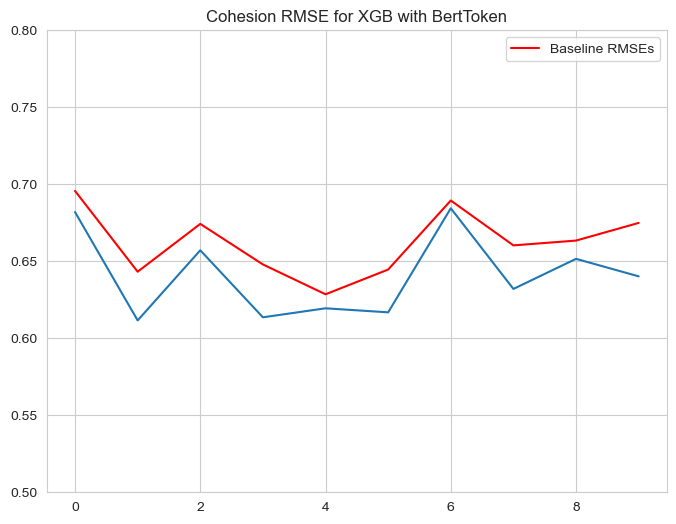

In [35]:
plt.figure(figsize=(8,6))

plt.plot(cv_rmses[:,0])
plt.plot(cv_rmses_baseline[:,0], 'r-', label="Baseline RMSEs")
plt.legend()
plt.ylim(.5, .8)
plt.title('Cohesion RMSE for XGB with BertToken')

plt.show()

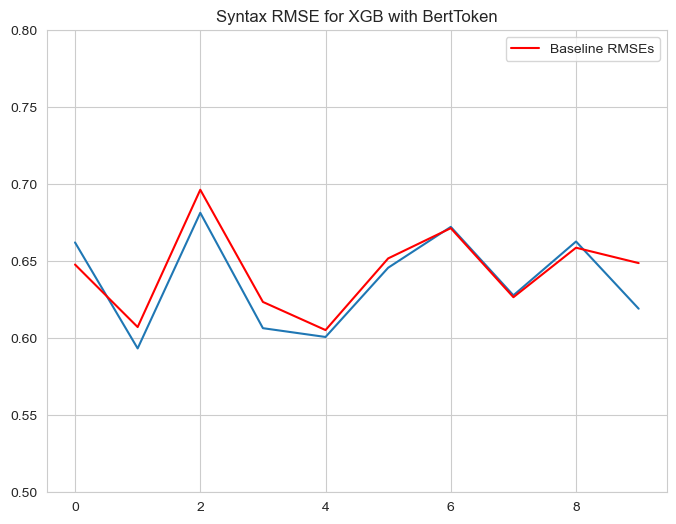

In [36]:
plt.figure(figsize=(8,6))

plt.plot(cv_rmses[:,1])
plt.plot(cv_rmses_baseline[:,1], 'r-', label="Baseline RMSEs")
plt.legend()
plt.ylim(.5, .8)
plt.title('Syntax RMSE for XGB with BertToken')

plt.show()

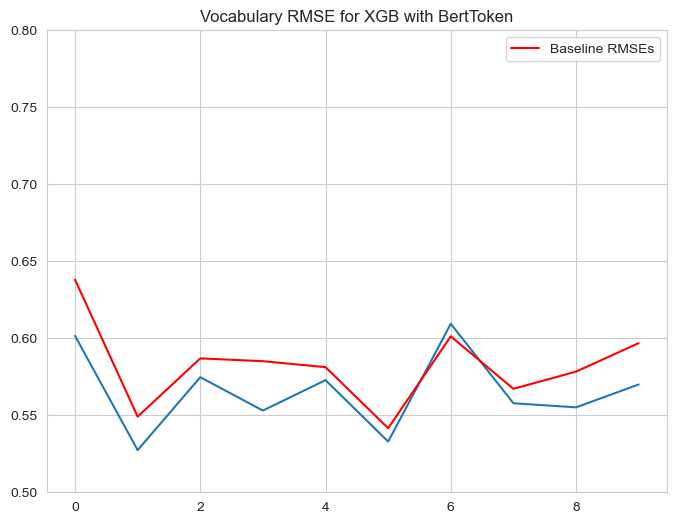

In [37]:
plt.figure(figsize=(8,6))

plt.plot(cv_rmses[:,2])
plt.plot(cv_rmses_baseline[:,2], 'r-', label="Baseline RMSEs")
plt.legend()
plt.ylim(.5, .8)
plt.title('Vocabulary RMSE for XGB with BertToken')

plt.show()

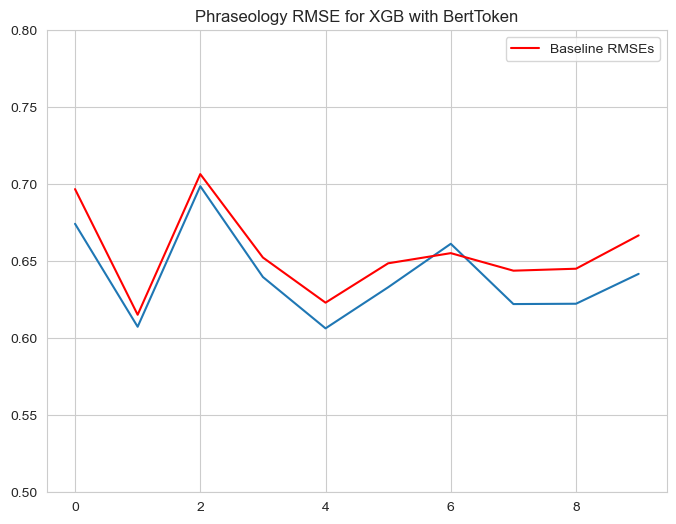

In [38]:
plt.figure(figsize=(8,6))

plt.plot(cv_rmses[:,3])
plt.plot(cv_rmses_baseline[:,3], 'r-', label="Baseline RMSEs")
plt.legend()
plt.ylim(.5, .8)
plt.title('Phraseology RMSE for XGB with BertToken')

plt.show()

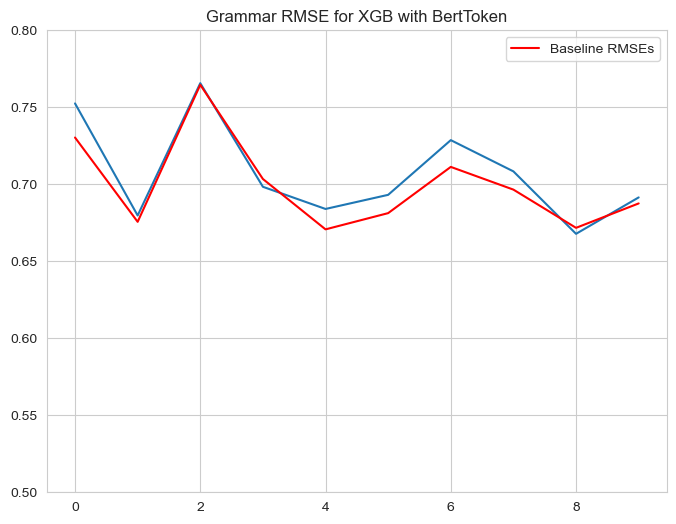

In [39]:
plt.figure(figsize=(8,6))

plt.plot(cv_rmses[:,4])
plt.plot(cv_rmses_baseline[:,4], 'r-', label="Baseline RMSEs")
plt.legend()
plt.ylim(.5, .8)
plt.title('Grammar RMSE for XGB with BertToken')

plt.show()

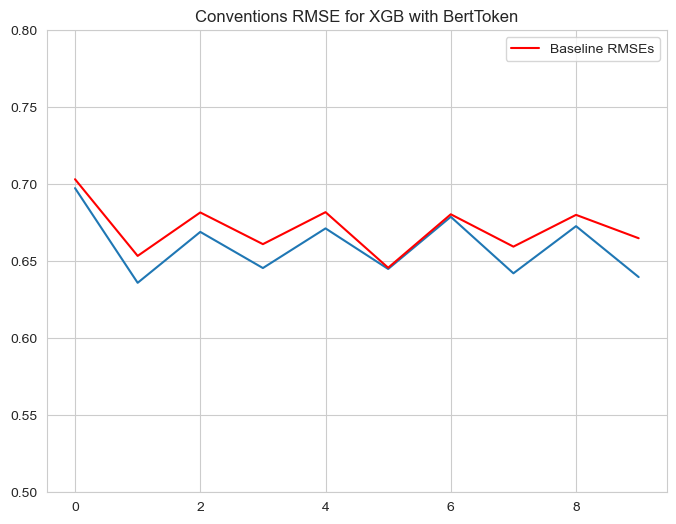

In [40]:
plt.figure(figsize=(8,6))

plt.plot(cv_rmses[:,5])
plt.plot(cv_rmses_baseline[:,5], 'r-', label="Baseline RMSEs")
plt.legend()
plt.ylim(.5, .8)
plt.title('Conventions RMSE for XGB with BertToken')

plt.show()

## MCRMSE of the Model

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
train_train, train_test, y_train, y_test = train_test_split(train_token, y_train,
                                                       shuffle = True,
                                                       random_state = 440,
                                                       test_size = .2)

In [43]:
xgb_estimator = xgb.XGBRegressor(n_estimators=100,
                                max_depth = 2,
                                objective='reg:squarederror')
model = MultiOutputRegressor(xgb_estimator, n_jobs=3)

model.fit(train_train, y_train)
predicted = model.predict(train_test)

bsl = np.ones((len(y_test),1))*np.mean(y_train, axis=0)

rmses = MSE(y_test, predicted, squared=False, multioutput='raw_values')

baseline = MSE(y_test, bsl, squared=False, multioutput='raw_values')

In [44]:
rmses

array([0.67010338, 0.64001961, 0.56756924, 0.64991656, 0.71517857,
       0.67036347])

In [45]:
baseline

array([0.68460606, 0.65301102, 0.57901074, 0.66458238, 0.69383323,
       0.67631762])

In [46]:
print('MCRMSE for XGBoost is', rmses.mean())

MCRMSE for XGBoost is 0.6521918044427301


In [47]:
print('MCRMSE for Baseline is', baseline.mean())

MCRMSE for Baseline is 0.6585601735707021
